# Using the sampler

`spvcm` is a generic gibbs sampling framework for spatially-correlated variance components models. The current supported models are:

- `spvcm.both` contains specifications with correlated errors in both levels, with the first statement `se/sma` describing the lower level and the second statement `se/sma` describing the upper level. In addition, `MVCM`, the multilevel variance components model with no spatial correlation, is in the `both` namespace. 
- `spvcm.lower` contains two specifications, `se/sma`, that can be used for a variance components model with correlated lower-level errors.
- `spvcm.upper` contains two specifications, `se/sma` that can be used for a variance components model with correlated upper-level errors. 

### Specification

These derive from a variance components specification: 

$$ Y \sim \mathcal{N}(X\beta, \Psi_1(\lambda, \sigma^2) + \Delta\Psi_2(\rho, \tau^2)\Delta') $$

Where:
1. $\beta$, called `Betas` in code, is the marginal effect parameter. In this implementation, any region-level covariates $Z$ get appended to the end of $X$. So, if $X$ is $n \times p$ ($n$ observations of $p$ covariates)  and $Z$ is $J \times p'$ ($p'$ covariates observed for $J$ regions), then the model's $X$ matrix is $n \times (p + p')$ and $\beta$ is $p + p' \times 1$. 
2. $\Psi_1$ is the covariance function for the response-level model. In the software, a separable covariance is assumed, so that $\Psi_1(\rho, \sigma^2) = \Psi_1(\rho) * I \sigma^2)$, where $I$ is the $n \times n$ covariance matrix. Thus, $\rho$ is the spatial autoregressive parameter and $\sigma^2$ is the variance parameter. In the software, $\Psi_1$ takes any of the following forms:
    - Spatial Error (`SE`): $\Psi_1(\rho) = [(I - \rho \mathbf{W})'(I - \rho \mathbf{W})]^{-1} \sigma^2$
    - Spatial Moving Average (`SMA`): $\Psi_1(\rho) = (I + \rho \mathbf{W})(I + \lambda \mathbf{W})'$
    - Identity: $\Psi_1(\rho) = I$
2. $\Psi_2$ is the region-level covariance function, with region-level autoregressive parameter $\lambda$ and region-level variance $\tau^2$. It has the same potential forms as $\Psi_1$. 
3. $\alpha$, called `Alphas` in code, is the region-level random effect. In a variance components model, this is interpreted as a random effect for the upper-level. For a Varying-intercept format, this random component should be added to a region-level fixed effect to provide the varying intercept. This may also make it more difficult to identify the spatial parameter. 

## Softare implementation

All of the possible combinations of Spatial Moving Average and Spatial Error processes are contained in the following classes. I will walk through estimating one below, and talk about the various features of the package. 

First, the API of the package is defined by the `spvcm.api` submodule. To load it, use `import spvcm.api as spvcm`:

In [1]:
import spvcm.api as spvcm #package API
spvcm.both.Generic # abstract customizable class, ignores rho/lambda, equivalent to MVCM
spvcm.both.MVCM # no spatial effect
spvcm.both.SESE #  both spatial error (SE)
spvcm.both.SESMA # response-level SE, region-level spatial moving average
spvcm.both.SMASE # response-level SMA, region-level SE
spvcm.both.SMASMA # both levels SMA
spvcm.upper.SE # response-level uncorrelated, region-level SE
spvcm.upper.SMA # response-level uncorrelated, region-level SMA
spvcm.lower.SE # response-level SE, region-level uncorrelated
spvcm.lower.SMA # response-level SMA, region-level uncorrelated 

spvcm.lower_level.sma.model.Lower_SMA

Depending on the structure of the model, you need at least:
- `X`, data at the response (lower) level
- `Y`, system response in the lower level
- `membership` or `Delta`, the membership vector relating each observation to its group or the "dummy variable" matrix encoding the same information. 

Then, if spatial correlation is desired, `M` is the "upper-level" weights matrix and `W` the lower-level weights matrix. 

Any upper-level data should be passed in $Z$, and have $J$ rows. To fit a varying-intercept model, include an identity matrix in $Z$. You can include state-level and response-level intercept terms simultaneously. 

Finally, there are many configuration and tuning options that can be passed in at the start, or assigned after the model is initialized. 

First, though, let's set up some data for a model on southern counties predicting `HR90`, the Homicide Rate in the US South in 1990, using the the percent of the labor force that is unemployed (`UE90`), a principal component expressing the population structure (`PS90`), and a principal component expressing resource deprivation. 

We will also use the state-level average percentage of families below the poverty line and the average Gini coefficient at the state level for a $Z$ variable. 

In [8]:
#seaborn is required for the traceplots
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

Reading in the data, we'll extract these values we need from the dataframe.

In [9]:
data = ps.pdio.read_files(ps.examples.get_path('south.shp'))
gdf = gpd.read_file(ps.examples.get_path('south.shp'))
data = data[data.STATE_NAME != 'District of Columbia']
X = data[['UE90', 'PS90', 'RD90']].values
N = X.shape[0]
Z = data.groupby('STATE_NAME')[['FP89', 'GI89']].mean().values
J = Z.shape[0]

Y = data.HR90.values.reshape(-1,1)

Then, we'll construct some queen contiguity weights from the files to show how to run a model. 

In [10]:
W2 = ps.queen_from_shapefile(ps.examples.get_path('us48.shp'), 
                             idVariable='STATE_NAME')
W2 = ps.w_subset(W2, ids=data.STATE_NAME.unique().tolist()) #only keep what's in the data
W1 = ps.queen_from_shapefile(ps.examples.get_path('south.shp'),
                             idVariable='FIPS')
W1 = ps.w_subset(W1, ids=data.FIPS.tolist()) #again, only keep what's in the data

W1.transform = 'r'
W2.transform = 'r'

With the data, upper-level weights, and lower-level weights, we can construct a membership vector *or* a dummy data matrix. For now, I'll create the membership vector.

In [5]:
membership = data.STATE_NAME.apply(lambda x: W2.id_order.index(x)).values

But, we could also build the dummy variable matrix using `pandas`, if we have a suitable categorical variable:

In [6]:
Delta_frame = pd.get_dummies(data.STATE_NAME)
Delta = Delta_frame.values

Every call to the sampler is of the following form:

`sampler(Y, X, W, M, Z, membership, Delta, n_samples, **configuration)`

Where `W`, `M` are passed if appropriate, `Z` is passed if used, and only one of `membership` or `Delta` is required. In the end, `Z` is appended to `X`, so the effects pertaining to the upper level will be at the tail end of the $\beta$ effects vector. If both `Delta` and `membership` are supplied, they're verified against each other to ensure that they agree before they are used in the model. 

For all models, the membership vector or an equivalent dummy variable matrix is required. For models with correlation in the upper level, only the upper-level weights matrix $\mathbf{M}$ is needed. For lower level models, the lower-level weights matrix $\mathbf{W}$ is required. For models with correlation in both levels, both $\mathbf{W}$ and $\mathbf{M}$ are required. 

Every sampler uses, either in whole or in part, `spvcm.both.generic`, which implements the full generic sampler discussed in the working paper. For efficiency, the upper-level samplers modify this runtime to avoid processing the full lower-level covariance matrix. 

Like many of the `R` packages dedicated to bayesian models, configuration occurs by passing the correct dictionary to the model call. In addition, you can "setup" the model, configure it, and then run samples in separate steps. 

The most common way to call the sampler is something like:

In [7]:
vcsma = spvcm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                      n_samples=5000,
                      configs=dict(tuning=1000, adapt_step=1.01))

 36%|███▌      | 1804/5000 [00:17<00:37, 84.67it/s]/home/ljw/Dropbox/dev/spvcm/spvcm/abstracts.py:65: UserWarning: Sampling interrupted, drew 1806 samples
  warnings.warn('Sampling interrupted, drew {} samples'.format(self.cycles))


This models, `spvcm.upper.SMA`, is a variance components/varying intercept model with a state-level SMA-correlated error. 

Thus, there are only five parameters in this model, since $\rho$, the lower-level autoregressive parameter, is constrained to zero:

In [8]:
vcsma.trace.varnames

['Betas', 'Tau2', 'Lambda', 'Sigma2', 'Alphas']

The results and state of the sampler are stored within the `vcsma` object. I'll step through the most important parts of this object. 

# `trace`

The quickest way to get information out of the model is via the trace object. This is where the results of the tracked parameters are stored each iteration. Any variable in the sampler state can be added to the tracked params. Trace objects are essentially dictionaries with the keys being the name of the tracked parameter and the values being a list of each iteration's sampler output.

In [9]:
vcsma.trace.varnames

['Betas', 'Tau2', 'Lambda', 'Sigma2', 'Alphas']

In this case, `Lambda` is the upper-level moving average parameter, `Alphas` is the vector of correlated group-level random effects, `Tau2` is the upper-level variance, `Betas` are the marginal effects, and `Sigma2` is the lower-level error variance.

I've written two helper functions for working with traces. First is to just dump all the output into a pandas dataframe, which makes it super easy to do work on the samples, or write them out to `csv` and assess convergence in R's `coda` package.

In [10]:
trace_dataframe = vcsma.trace.to_df()

the dataframe will have columns containing the elements of the parameters and each row is a single iteration of the sampler:

In [11]:
trace_dataframe.head()

,Tau2,Lambda,Sigma2,Betas_0,Betas_1,Betas_2,Betas_3,Betas_4,Betas_5,Alphas_0,...,Alphas_6,Alphas_7,Alphas_8,Alphas_9,Alphas_10,Alphas_11,Alphas_12,Alphas_13,Alphas_14,Alphas_15
0,1.609701,-0.037596,31.631548,8.646048,-0.520705,1.998185,4.537999,-0.025337,6.032380,-1.254059,...,-0.078338,0.781005,0.332664,-0.021977,0.054487,-0.471622,0.120874,1.791483,-0.896495,2.320426
1,8.198928,-0.037596,32.214930,3.303455,-0.215991,1.548661,4.137363,-0.112102,18.576893,-1.467829,...,-0.265317,1.165560,0.439342,-0.053223,0.973737,-0.526876,-0.190646,1.501436,-1.208158,2.076981
2,1.678622,-0.209093,33.875582,9.274554,-0.228063,1.858002,3.891786,-0.011377,-0.357544,-2.363754,...,-0.132188,1.157237,-0.001925,0.766132,1.442822,-0.510606,0.843578,1.252048,-2.261098,1.474907
3,1.960018,0.473230,29.674127,8.175505,-0.183321,1.610702,3.570144,-0.047974,3.847056,-1.989813,...,0.210033,0.890912,-0.000089,-1.244827,0.154213,-0.281526,0.288401,1.676196,-0.581796,1.128016
4,1.470679,0.644062,31.232812,9.369089,-0.229567,1.748843,4.096779,-0.023223,0.205645,-2.304124,...,-1.702688,-0.013704,-0.134672,-0.074171,0.931683,-0.671555,-0.976901,1.761726,-1.487481,2.309169


You can write this out to a csv or analyze it in memory like a typical pandas dataframes:

In [12]:
trace_dataframe.mean()

Tau2          1.895557
Lambda        0.577603
Sigma2       32.214985
Betas_0       8.273556
Betas_1      -0.260775
Betas_2       1.795423
Betas_3       3.976565
Betas_4      -0.014292
Betas_5       2.220330
Alphas_0     -1.573708
Alphas_1     -0.145376
Alphas_2     -0.115448
Alphas_3      0.041912
Alphas_4     -2.248593
Alphas_5     -0.901895
Alphas_6     -0.331669
Alphas_7      1.052897
Alphas_8      0.209027
Alphas_9     -0.171696
Alphas_10     1.005403
Alphas_11     0.300665
Alphas_12     0.204068
Alphas_13     1.896521
Alphas_14    -0.671077
Alphas_15     2.140002
dtype: float64

The second is a method to plot the traces:

/home/ljw/anaconda3/envs/py36/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


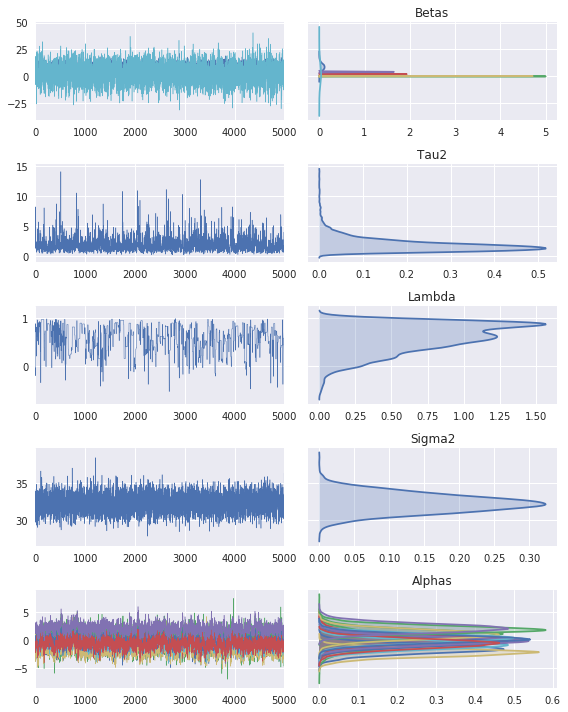

In [13]:
fig, ax = vcsma.trace.plot()
plt.show()

The trace object can be sliced by (chain, parameter, index) tuples, or any subset thereof. 

In [14]:
vcsma.trace['Lambda',-4:] #last 4 draws of lambda

array([ 0.69935639,  0.69935639,  0.71225313,  0.71225313])

In [15]:
vcsma.trace[['Tau2', 'Sigma2'], 0:2] #the first 2 variance parameters

{'Sigma2': [31.631548022205266, 32.214929751081115],
 'Tau2': [1.6097008922179674, 8.1989278486256847]}

We only ran a single chain, so the first index is assumed to be zero. You can run more than one chain in parallel, using the builtin python `multiprocessing` library:

In [16]:
vcsma_p = spvcm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                        n_samples=5000, n_jobs=3, #run 3 chains
                        configs=dict(tuning=500, adapt_step=1.01))

In [17]:
vcsma_p.trace[0, 'Betas', -1] #the last draw of Beta on the first chain. 

array([[ 10.01258289],
       [ -0.30455162],
       [  2.02245357],
       [  4.10752171],
       [ -0.11566565],
       [  2.17141118]])

In [18]:
vcsma_p.trace[1, 'Betas', -1] #the last draw of Beta on the second chain

array([[  4.35773397],
       [ -0.33084418],
       [  1.58599159],
       [  4.18474527],
       [  0.05850114],
       [ 10.38329614]])

and the chain plotting works also for the multi-chain traces. In addition, there are quite a few traceplot options, and all the plots are returned by the methods as matplotlib objects, so they can also be saved using `plt.savefig()`. 

/home/ljw/anaconda3/envs/py36/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


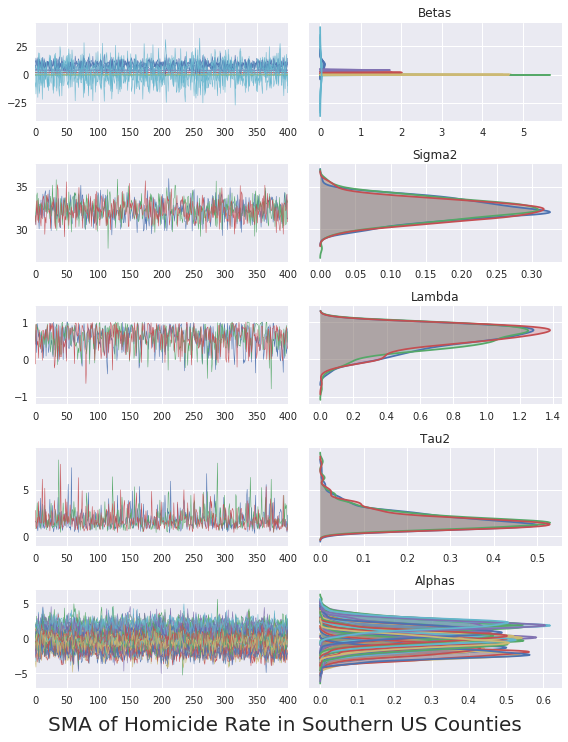

In [19]:
vcsma_p.trace.plot(burn=1000, thin=10)
plt.suptitle('SMA of Homicide Rate in Southern US Counties', y=0, fontsize=20)
#plt.savefig('trace.png') #saves to a file called "trace.png"
plt.show()

/home/ljw/anaconda3/envs/py36/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


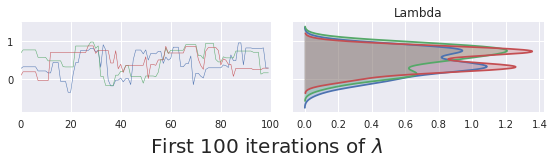

In [20]:
vcsma_p.trace.plot(burn=-100, varnames='Lambda') #A negative burn-in works like negative indexing in Python & R 
plt.suptitle('First 100 iterations of $\lambda$', fontsize=20, y=.02)
plt.show() #so this plots Lambda in the first 100 iterations. 

To get stuff like posterior quantiles, you can use the attendant pandas dataframe functionality, like `describe`. 

In [21]:
df = vcsma.trace.to_df()

In [22]:
df.describe()

,Tau2,Lambda,Sigma2,Betas_0,Betas_1,Betas_2,Betas_3,Betas_4,Betas_5,Alphas_0,...,Alphas_6,Alphas_7,Alphas_8,Alphas_9,Alphas_10,Alphas_11,Alphas_12,Alphas_13,Alphas_14,Alphas_15
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.895557,0.577603,32.214985,8.273556,-0.260775,1.795423,3.976565,-0.014292,2.220330,-1.573708,...,-0.331669,1.052897,0.209027,-0.171696,1.005403,0.300665,0.204068,1.896521,-0.671077,2.140002
std,1.164950,0.294818,1.234452,3.230874,0.080253,0.204405,0.233755,0.089643,9.448804,0.848927,...,0.850966,0.903979,0.889011,0.784543,0.862906,0.793808,0.771146,0.719722,0.872830,0.820967
min,0.244171,-0.542780,27.797235,-3.517124,-0.556882,1.138948,3.091075,-0.438212,-31.796046,-4.872318,...,-4.195622,-2.729693,-2.851342,-4.158377,-2.034867,-3.217195,-2.803899,-0.468388,-3.998393,-0.294003
25%,1.148728,0.397292,31.355758,6.070975,-0.313902,1.655756,3.815131,-0.071056,-4.192499,-2.117915,...,-0.882611,0.471287,-0.356979,-0.657930,0.430419,-0.240387,-0.292068,1.418873,-1.238230,1.565083
50%,1.627934,0.623599,32.175043,8.288137,-0.260673,1.796586,3.978004,-0.014070,2.323148,-1.560600,...,-0.336238,1.044827,0.174966,-0.163271,0.999208,0.313084,0.190650,1.856719,-0.635872,2.103491
75%,2.291793,0.830463,33.023407,10.474560,-0.208057,1.931622,4.138010,0.042823,8.661959,-0.996418,...,0.213909,1.617882,0.761905,0.320577,1.573788,0.832825,0.697769,2.347737,-0.079606,2.660972
max,14.034481,0.995255,38.374266,21.310856,0.079064,2.470916,4.861402,0.373824,40.577080,1.471691,...,3.348637,4.476770,4.630863,2.828693,4.739110,3.029009,3.373398,5.063581,1.888735,5.912762


There is also a `trace.summarize` function that will compute various things contained in `spvcm.diagnostics` on the chain. It takes a while for large chains, because the `statsmodels.tsa.AR` estimator is much slower than the `ar` estimator in `R`. If you have rpy2 installed *and* `CODA` installed in your R environment, I attempt to use R directly. 

In [23]:
vcsma.trace.summarize()

mean    HPD_low     median   HPD_high       std  \
Chain_0 Sigma2     32.214985  29.874377  32.175043  34.683956  1.234452   
        Lambda      0.577603   0.016845   0.623599   0.995255  0.294818   
        Tau2        1.895557   0.337406   1.627934   4.101091  1.164950   
        Betas_0     8.273556   1.640598   8.288137  14.226929  3.230874   
        Betas_1    -0.260775  -0.426642  -0.260673  -0.108877  0.080253   
        Betas_2     1.795423   1.408993   1.796586   2.217123  0.204405   
        Betas_3     3.976565   3.539227   3.978004   4.436255  0.233755   
        Betas_4    -0.014292  -0.192609  -0.014070   0.161317  0.089643   
        Betas_5     2.220330 -16.083196   2.323148  20.681799  9.448804   
        Alphas_0   -1.573708  -3.255273  -1.560600   0.138350  0.848927   
        Alphas_1   -0.145376  -2.894310  -0.159614   2.400211  1.342653   
        Alphas_2   -0.115448  -1.967762  -0.114669   1.955506  0.994694   
        Alphas_3    0.041912  -1.448841   0.031702   1.564431  0.759920   
        Alphas_4   -2.248593  -3.763959  -2.213933  -0.868567  0.730432   
        Alphas_5   -0.901895  -2.552021  -0.884008   0.685102  0.833995   
        Alphas_6   -0.331669  -2.058371  -0.336238   1.310624  0.850966   
        Alphas_7    1.052897  -0.747657   1.044827   2.858916  0.903979   
        Alphas_8    0.209027  -1.551266   0.174966   1.963306  0.889011   
        Alphas_9   -0.171696  -1.781736  -0.163271   1.388258  0.784543   
        Alphas_10   1.005403  -0.778483   0.999208   2.620234  0.862906   
        Alphas_11   0.300665  -1.184594   0.313084   1.861771  0.793808   
        Alphas_12   0.204068  -1.302115   0.190650   1.756572  0.771146   
        Alphas_13   1.896521   0.436822   1.856719   3.307145  0.719722   
        Alphas_14  -0.671077  -2.379407  -0.635872   1.027875  0.872830   
        Alphas_15   2.140002   0.634657   2.103491   3.816575  0.820967   

                   N_iters  N_effective  AR_loss  
Chain_0 Sigma2        5000         4610   0.0780  
        Lambda        5000          271   0.9458  
        Tau2          5000          843   0.8314  
        Betas_0       5000         1790   0.6420  
        Betas_1       5000         2210   0.5580  
        Betas_2       5000         4543   0.0914  
        Betas_3       5000         3170   0.3660  
        Betas_4       5000          455   0.9090  
        Betas_5       5000         3420   0.3160  
        Alphas_0      5000          437   0.9126  
        Alphas_1      5000         3236   0.3528  
        Alphas_2      5000          885   0.8230  
        Alphas_3      5000          363   0.9274  
        Alphas_4      5000          341   0.9318  
        Alphas_5      5000          312   0.9376  
        Alphas_6      5000          295   0.9410  
        Alphas_7      5000          416   0.9168  
        Alphas_8      5000          214   0.9572  
        Alphas_9      5000          404   0.9192  
        Alphas_10     5000          504   0.8992  
        Alphas_11     5000          433   0.9134  
        Alphas_12     5000          484   0.9032  
        Alphas_13     5000          269   0.9462  
        Alphas_14     5000          431   0.9138  
        Alphas_15     5000          391   0.9218

So, 5000 iterations, but many parameters have an effective sample size that's much less than this. There's debate about whether it's necesasry to thin these samples in accordance with the effective size, and I think you should thin your sample to the effective size and see if it affects your HPD/Standard Errorrs. 

The existing python packages for MCMC diagnostics were incorrect. So, I've implemented many of the diagnostics from `CODA`, and have verified that the diagnostics comport with `CODA` diagnostics. One can also use `numpy` & `statsmodels` functions. I'll show some types of analysis.

In [24]:
from statsmodels.api import tsa
#if you don't have it, try removing the comment and:
#! pip install statsmodels

For example, a plot of the partial autocorrelation in $\lambda$, the upper-level spatial moving average parameter, over the last half of the chain is:

/home/ljw/anaconda3/envs/py36/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


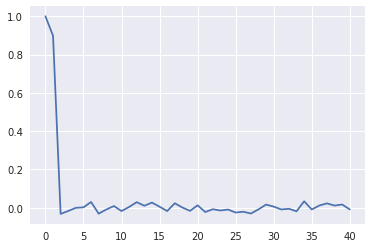

In [25]:
plt.plot(tsa.pacf(vcsma.trace['Lambda', -2500:]))

So, the chain is close-to-first order:

In [26]:
tsa.pacf(df.Lambda)[0:3]

array([ 1.        ,  0.89724693, -0.00775044])

We could do this for many parameters, too. An Autocorrelation/Partial Autocorrelation plot can be made of the marginal effects by:

/home/ljw/anaconda3/envs/py36/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


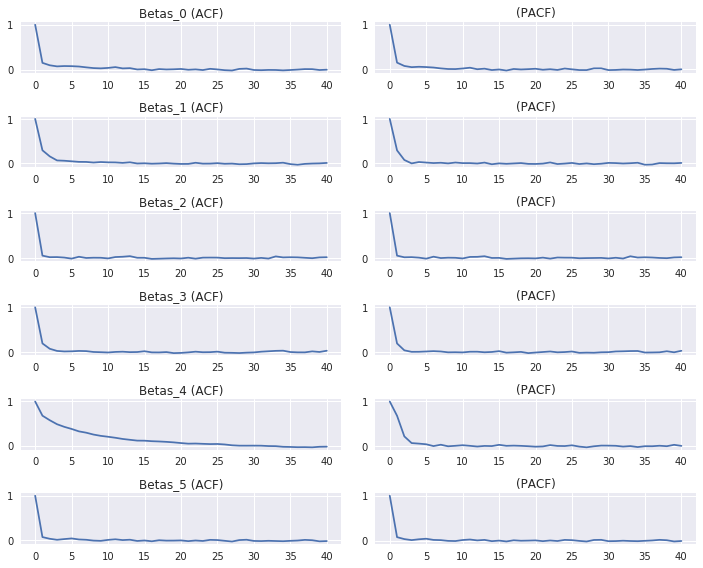

In [27]:
betas = [c for c in df.columns if c.startswith('Beta')]
f,ax = plt.subplots(len(betas), 2, figsize=(10,8))
for i, col in enumerate(betas):
    ax[i,0].plot(tsa.acf(df[col].values))
    ax[i,1].plot(tsa.pacf(df[col].values)) #the pacf plots take a while
    ax[i,0].set_title(col +' (ACF)')
    ax[i,1].set_title('(PACF)')
f.tight_layout()
plt.show()

As far as the builtin diagnostics for convergence and simulation quality, the `diagnostics` module exposes a few things:

Geweke statistics for differences in means between chain components:

In [28]:
gstats = spvcm.diagnostics.geweke(vcsma, varnames='Tau2') #takes a while
print(gstats)

[{'Tau2': array([ -3.18950992e-01,   4.19137545e-01,   3.04751994e-01,
         4.54512673e-01,  -6.10265658e-03,   3.69155830e-01,
         3.06154379e-01,   7.23711214e-01,   1.56252173e+00,
         1.09291567e+00,   7.60605455e-01,  -2.23118055e-01,
        -2.21673504e-01,  -1.26062494e-01,   9.07152460e-02,
        -9.17643267e-04,   3.32498641e-01,  -1.57557774e+00,
        -9.67041933e-01,   3.97682583e-01,   4.20375026e-01,
         6.76782980e-01,   6.66081728e-02,   1.23641661e-01,
         6.36799028e-02,  -1.92992176e-01,  -5.71545948e-01,
        -2.61003266e+00,  -3.02365972e-01,  -4.43889534e-01,
         5.99363448e-02,  -1.57991091e-01,  -1.61431085e-01,
         2.91314652e-01,   9.95650116e-01,   9.54890443e-01,
         1.09000027e+00,   8.54711884e-01,   1.12127471e+00,
         1.38599412e+00,   1.39890942e+00,   1.35416188e-01,
         2.75356187e-02,   7.28415405e-01,   2.67666276e-01,
        -7.86796946e-01,  -1.96561589e-01,   9.65528749e-01,
         1.422

Typically, this means the chain is converged at the given "bin" count if the line stays within $\pm2$. The geweke statistic is a test of differences in means between the given chunk of the chain and the remaining chain. If it's outside of +/- 2 in the early part of the chain, you should discard observations early in the chain. If you get extreme values of these statistics throughout, you need to keep running the chain. 

/home/ljw/anaconda3/envs/py36/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


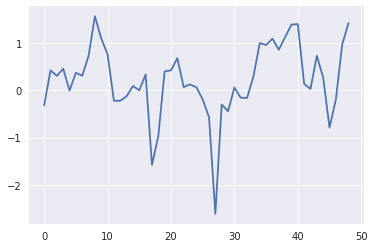

In [29]:
plt.plot(gstats[0]['Tau2'][:-1])

We can also compute Monte Carlo Standard Errors like in the `mcse` R package, which represent the intrinsic error contained in the estimate:

In [30]:
spvcm.diagnostics.mcse(vcsma, varnames=['Tau2', 'Sigma2'])

{'Sigma2': 0.018508785149475137, 'Tau2': 0.038375245903180678}

Another handy statistic is the Partial Scale Reduction factor, which measures of how likely a set of chains run in parallel have converged to the same stationary distribution. It provides the difference in variance between between chains vs. within chains. 

If these are significantly larger than one (say, 1.5), the chain probably has not converged. Being marginally below $1$ is fine, too.

In [31]:
spvcm.diagnostics.psrf(vcsma_p, varnames=['Tau2', 'Sigma2'])

{'Sigma2': 0.99991487566874293, 'Tau2': 1.0007715009131}

Highest posterior density intervals provide a kind of interval estimate for parameters in Bayesian models:

In [32]:
spvcm.diagnostics.hpd_interval(vcsma, varnames=['Betas', 'Lambda', 'Sigma2'])

{'Betas': [(1.6405978541790658, 14.226928758479556),
  (-0.42664154951141753, -0.10887678036377707),
  (1.4089929469217661, 2.2171233117601759),
  (3.5392266408878719, 4.4362551104254697),
  (-0.19260929003770938, 0.16131717634681292),
  (-16.083195900918767, 20.681798559113616)],
 'Lambda': (0.016844807210006918, 0.99525450407273097),
 'Sigma2': (29.874376971288243, 34.683955921766042)}

Sometimes, you want to apply arbitrary functions to each parameter trace. To do this, I've written a `map` function that works like the python builtin `map`. For example, if you wanted to get arbitrary percentiles from the chain:

In [33]:
vcsma.trace.map(np.percentile, 
                varnames=['Lambda', 'Tau2', 'Sigma2'],
                #arguments to pass to the function go last
                q=[25, 50, 75]) 

[{'Lambda': array([ 0.39729235,  0.62359855,  0.83046319]),
  'Sigma2': array([ 31.35575771,  32.17504291,  33.02340722]),
  'Tau2': array([ 1.1487285 ,  1.62793386,  2.2917925 ])}]

In addition, you can pop the trace results pretty simply to a `.csv` file and analyze it elsewhere, like if you want to use use the `coda` Bayesian Diagnostics package in `R`. 

To write out a model to a csv, you can use:

In [34]:
vcsma.trace.to_csv('./model_run.csv')

And, you can even load traces from csvs:

['Betas', 'Lambda', 'Sigma2', 'Alphas', 'Tau2']


/home/ljw/anaconda3/envs/py36/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(<matplotlib.figure.Figure at 0x7f39973d1208>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39951634a8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f3994fe1080>]], dtype=object))

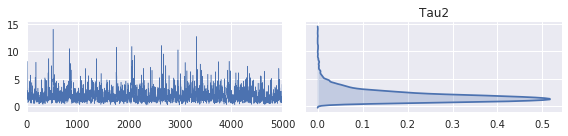

In [35]:
tr = spvcm.Trace.from_csv('./model_run.csv')
print(tr.varnames)
tr.plot(varnames=['Tau2'])

#  Working with models: `draw` and `sample`

These two functions are used to call the underlying Gibbs sampler. They take no arguments, and operate on the sampler in place. `draw` provides a single new sample:

In [36]:
vcsma.draw()

And sample steps forward an arbitrary number of times:

In [37]:
vcsma.sample(10)

At this point, we did 5000 initial samples and 11 extra samples. Thus:

In [38]:
vcsma.cycles

5011

Parallel models can suspend/resume sampling too:

In [39]:
vcsma_p.sample(10)

In [40]:
vcsma_p.cycles

5010

Under the hood, it's the `draw` method that actually ends up calling one run of `model._iteration`, which is where the actual statistical code lives. Then, it updates all `model.traced_params` by adding their current value in `model.state` to `model.trace.` In addition, `model._finalize` is called the first time sampling is run, which computes some of the constants & derived quantities that save computing time.

# Working with models:  `state`

This is the collection of current values in the sampler. To be efficient, Gibbs sampling must keep around some of the computations used in the simulation, since sometimes the same terms show up in different conditional posteriors. So, the current values of the sampler are stored in `state`.

All of the following are tracked in the state:

In [41]:
print(vcsma.state.keys())

dict_keys(['Psi_1', 'In', 'Sigma2', 'XBetas', 'p', 'Psi_2i', 'DeltaAlphas', 'PsiLambdai', 'Sigma2_an', 'Betas_cov0', 'Betas_cov0i', 'DeltatDelta', 'Y', 'Lambda', 'Lambda_max', 'XtX', 'Psi_1i', 'Alphas', 'X', 'Sigma2_a0', 'Tau2_a0', 'Log_Lambda0', 'M', 'Delta', 'Rho', 'Rho_min', 'Sigma2_b0', 'Rho_max', 'J', 'Ij', 'PsiRhoi', 'Tau2_b0', 'W', 'Betas', 'Betas_covm', 'Betas_mean0', 'Tau2_an', 'Tau2', 'Lambda_min', 'Log_Rho0', 'Psi_2', 'initial_values', 'N'])


If you want to track how something (maybe a hyperparameter) changes over sampling, you can pass `extra_traced_params` to the model declaration:

In [42]:
example = spvcm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                        n_samples=250, 
                        extra_traced_params = ['DeltaAlphas'],
                        configs=dict(tuning=500, adapt_step=1.01))
example.trace.varnames

['Betas', 'Tau2', 'Lambda', 'Sigma2', 'Alphas', 'DeltaAlphas']

# `configs`
this is where configuration options for the various MCMC steps are stored. For multilevel variance components models, these are called $\rho$ for the lower-level error parameter and $\lamdba$ for the upper-level parameter. Two exact sampling methods are implemented, Metropolis sampling & Slice sampling. 

Each MCMC step has its own config:

In [43]:
vcsma.configs

{'Lambda': <spvcm.steps.Metropolis at 0x7f39b500d160>,
 'Rho': <spvcm.steps.Metropolis at 0x7f39b500d128>}

Since `vcsma` is an upper-level-only model, the `Rho` config is skipped. But, we can look at the `Lambda` config. The number of accepted `lambda` draws is contained in :

In [44]:
vcsma.configs.Lambda.accepted

704

so, the acceptance rate is

In [45]:
vcsma.configs.Lambda.accepted / float(vcsma.cycles)

0.14049091997605268

Also, if you want to get verbose output from the metropolis sampler, there is a "debug" flag:

In [46]:
example = spvcm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                        n_samples=500, 
                        configs=dict(tuning=250, adapt_step=1.01, 
                                     debug=True))

Which stores the information about each iteration in a list, accessible from `model.configs.<parameter>._cache`:

In [47]:
example.configs.Lambda._cache[-1] #let's only look at the last one

{'accepted': False,
 'current_logp': array([-7.63740435]),
 'jump': 4.040717594517359,
 'new_logp': array([-7.63740435])}

Configuration of the MCMC steps is done using the `config` options dictionary, like done in `spBayes` in `R`. The actual configuration classes exist in spvcm.steps:

In [48]:
from spvcm.steps import Metropolis, Slice

Most of the common options are:

### Metropolis 
- `jump`: the starting standard deviation of the proposal distribution
- `tuning`: the number of iterations to tune the scale of the proposal
- `ar_low`: the lower bound of the target acceptance rate range
- `ar_hi`: the upper bound of the target acceptance rate range
- `adapt_step`: a number (bigger than 1) that will be used to modify the jump in order to keep the acceptance rate betwen `ar_lo` and `ar_hi`. Values much larger than `1` result in much more dramatic tuning. 

### Slice
- `width`: starting width of the level set
- `adapt`: number of previous slices use in the weighted average for the next slice. If `0`, the `width` is not dynamically tuned. 

In [49]:
example = spvcm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                        n_samples=500, 
                        configs=dict(tuning=250, adapt_step=1.01, 
                                     debug=True, ar_low=.1, ar_hi=.4))

In [50]:
example.configs.Lambda.ar_hi, example.configs.Lambda.ar_low

(0.4, 0.1)

In [51]:
example_slicer = spvcm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                               n_samples=500, 
                               configs=dict(Lambda_method='slice'))

/home/ljw/anaconda3/envs/py36/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


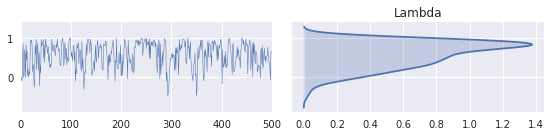

In [52]:
example_slicer.trace.plot(varnames='Lambda')
plt.show()

In [53]:
example_slicer.configs.Lambda.adapt, example_slicer.configs.Lambda.width

(0, 0.5)

# Working with models: customization

If you're doing heavy customization, it makes the most sense to first initialize the class without sampling. We did this before when showing how the "extra_traced_params" option worked. 

To show, let's initialize a double-level SAR-Error variance components model, but not actually draw anything.

To do this, you pass the option `n_samples=0`.

In [54]:
vcsese = spvcm.both.SESE(Y, X, W=W1, M=W2, Z=Z, membership=membership, 
                      n_samples=0)

This sets up a two-level spatial error model with the default uninformative configuration. This means the prior precisions are all `I * .001*`, prior means are all 0, spatial parameters are set to `-1/(n-1)`, and prior scale factors are set arbitrarily. 

### Configs

Options are set by assgning to the relevant property in `model.configs`. 

The model configuration object is another dictionary with a few special methods. 

Configuration options are stored for each parameter separately:

In [55]:
vcsese.configs

{'Lambda': <spvcm.steps.Metropolis at 0x7f3994693ac8>,
 'Rho': <spvcm.steps.Metropolis at 0x7f3994693668>}

So, for example, if we wanted to turn off adaptation in the upper-level parameter, and fix the Metrpolis jump variance to `.25`:

In [56]:
vcsese.configs.Lambda.max_tuning = 0
vcsese.configs.Lambda.jump  = .25

### Priors

Another thing that might be interesting (though not "bayesian") would be to fix the prior mean of $\beta$ to the OLS estimates. One way this could be done would be to pull the `Delta` matrix out from the state, and estimate:
$$ Y = X\beta + \Delta Z + \epsilon $$
using `PySAL`: 

In [57]:
Delta = vcsese.state.Delta
DeltaZ = Delta.dot(Z)
vcsese.state.Betas_mean0 = ps.spreg.OLS(Y, np.hstack((X, DeltaZ))).betas

### Starting Values

If you wanted to start the sampler at a given starting value, you can do so by assigning that value to the `Lambda` value in `state`. 

In [58]:
vcsese.state.Lambda = -.25

Sometimes, it's suggested that you start the beta vector randomly, rather than at zero. For the parallel sampling, the model starting values are adjusted to induce overdispersion in the start values. 

You could do this manually, too:

In [59]:
vcsese.state.Betas += np.random.uniform(-10, 10, size=(vcsese.state.p,1))

### Spatial Priors

Changing the spatial parameter priors is also done by changing their prior in state. This prior must be a function that takes a value of the parameter and return the log of the prior probability for that value. 

For example, we could assign `P(\lambda) = Beta(2,1)` and zero if outside $(0,1)$, and asign $\rho$ a truncated $\mathcal{N}(0,.5)$ prior by first defining their functional form:

In [60]:
from scipy import stats

In [61]:
def Lambda_prior(val):
    if (val < 0) or (val > 1):
        return -np.inf
    return np.log(stats.beta.pdf(val, 2,1))

In [62]:
def Rho_prior(val):
    if (val > .5) or (val < -.5):
        return -np.inf
    return np.log(stats.truncnorm.pdf(val, -.5, .5, loc=0, scale=.5))

And then assigning to their symbols, `LogLambda0` and `LogRho0` in the state:

In [63]:
vcsese.state.LogLambda0 = Lambda_prior
vcsese.state.LogRho0 = Rho_prior

### Performance

The efficiency of the sampler is contingent on the lower-level size. If we were to estimate the draw in a dual-level SAR-Error Variance Components iteration:

In [64]:
%timeit vcsese.draw()

10 loops, best of 3: 30.1 ms per loop


To make it easy to work with the model, you can interrupt and resume sampling using keyboard interrupts (`ctrl-c` or the `stop` button in the notebook). 

In [65]:
%time vcsese.sample(100)

CPU times: user 6.64 s, sys: 100 ms, total: 6.74 s
Wall time: 3.38 s


In [66]:
vcsese.sample(10)

# Under the Hood

### Package Structure

Most of the tools in the package are stored in relevant python files in the top level or a dedicated subfolder. Explaining a few:

- `abstracts.py` - the abstract class machinery to iterate over a sampling loop. This is where the classes are defined, like `Trace`, `Sampler_Mixin`, or `Hashmap`. 
- `plotting.py` - tools for plotting output
- `steps.py` - the step method definitions
- `verify.py` - like `user` checks in `pysal.spreg`, this contains a few sanity checks. 
- `utils.py`- contains statistical or numerical utilities to make the computation easier, like cholesky multivariate normal sampling, more sparse utility functions, etc. 
- `diagnostics.py` - all the diagnostics
- `priors.py` - definitions of alternative prior forms. Right now, this is pretty simple. 
- `sqlite.py` - functions to use a sqlite database instead of an in-memory chain are defined here. 

### The implementation of a Model

The package is implemented so that every "model type" first sends off to the `spvcm.both.Base_Generic`, which sets up the state, trace, and priors. 

Models are added by writing a `model.py` file and possibly a `sample.py` file. The `model.py` file defines a `Base/User` class pair (like `spreg`) that sets up the state and trace. It must define hyperparameters, and can precompute objects used in the sampling loop. The base class should inherit from `Sampler_Mixin`, which defines all of the machinery of sampling. 

The loop through the conditional posteriors should be defined in `model.py`, in the `model._iteration` function. This should update the model state in place.

The model may also define a `_finalize` function which is run once before sampling. 

So, if I write a new model, like a varying-intercept model with endogenously-lagged intercepts, I would write a `model.py` containing something like:
```python

class Base_VISAR(spvcm.generic.Base_Generic):
    def __init__(self, Y, X, M, membership=None, Delta=None,
                 extra_traced_params=None, #record extra things in state
                 n_samples=1000, n_jobs=1, #sampling config
                 priors = None, # dict with prior values for params
                 configs=None, # dict with configs for MCMC steps
                 starting_values=None, # dict with starting values
                 truncation=None, # options to truncate MCMC step priors
                 center=False, # Whether to center the X,Z matrices
                 scale=False # Whether re-scale the X,Z matrices
                 ):
        super(Base_VISAR, self).__init__(self, Y, X, M, W=None,
                                         membership=membership,
                                         Delta=Delta,
                                         n_samples=0, n_jobs=n_jobs,
                                         priors=priors, configs=configs,
                                         starting_values=starting_values,
                                         truncation=truncation,
                                         center=center,
                                         scale=scale
                                         )
        self.sample(n_samples, n_jobs=n_jobs)
        
        def _finalize(self):
            # the degrees of freedom of the variance parameter is constant
            self.state.Sigma2_an = self.state.N/2 + self.state.Sigma2_a0
            ...
        
        def _iteration(self):
            
            # computing the values needed to sample from the conditional posteriors
            mean = spdot(X.T, spdot(self.PsiRhoi, X)) / Sigma2 + self.state.bmean0
            ...
    ...
```
I've organized the directories in this project into `both_levels`, `upper_level`, `lower_level`, and `hierarchical`, which contains some of the spatially-varying coefficient models & other models I'm working on that are unrelated to the multilevel variance components stuff. 

Since most of the `_iteration` loop is the same between models, most of the models share the same sampling code, but customize the structure of the covariance in each level. These covariance variables are stored in the `state.Psi_1`, for the lower-level covariance, and `state.Psi_2` for the upper-level covariance. Likewise, the precision functions are `state.Psi_1i` and `state.Psi_2i`. 

For example:

In [67]:
vcsese.state.Psi_1 #lower-level covariance

<function spvcm.utils.se_covariance>

In [68]:
vcsese.state.Psi_2 #upper-level covariance

<function spvcm.utils.se_covariance>

In [69]:
vcsma.state.Psi_2 #upper-level covariance

<function spvcm.utils.sma_covariance>

In [70]:
vcsma.state.Psi_2i

<function spvcm.utils.sma_precision>

In [71]:
vcsma.state.Psi_1

<function spvcm.utils.ind_covariance>

The functions that generate the covariance matrices are stored in `spvcm.utils`. They can be arbitrarily overwritten for alternative covariance specifications. 

Thus, if we want to sample a model with a new covariance specification, then we need to define functions for the variance and precision.